In [14]:
import os
os.chdir("/home/arijit/Documents/rice_project")
print("CWD fixed:", os.getcwd())


CWD fixed: /home/arijit/Documents/rice_project


In [20]:
import csv
import json
import random
from pathlib import Path
from collections import Counter
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [6]:
PROJECT_ROOT = Path.home() / "Documents" / "rice_project"

RAW_DIR = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"

SEED = 20260115
TRAIN_FRAC = 0.60
VAL_FRAC = 0.20
TEST_FRAC = 0.20

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR exists:", RAW_DIR.exists())
print("SPLITS_DIR:", SPLITS_DIR)


PROJECT_ROOT: /home/arijit/Documents/rice_project
RAW_DIR exists: True
SPLITS_DIR: /home/arijit/Documents/rice_project/data/splits


### Dataset audit `(classes + counts)`

In [7]:
# list class folders
class_dirs = sorted([p for p in RAW_DIR.iterdir() if p.is_dir()])
print("Number of class folders:", len(class_dirs))
print("First 10 class names:", [p.name for p in class_dirs[:10]])

# count images per class
class_counts = {}
for cdir in class_dirs:
    files = [p for p in cdir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    class_counts[cdir.name] = len(files)

# print summary
counts = list(class_counts.values())
print("Min images/class:", min(counts))
print("Max images/class:", max(counts))
print("Unique counts:", sorted(set(counts))[:10], "..." if len(set(counts)) > 10 else "")

# show any classes not equal to 500
bad = {k: v for k, v in class_counts.items() if v != 500}
print("Classes with count != 500:", bad if bad else "None ✅")


Number of class folders: 38
First 10 class names: ['BD30', 'BD33', 'BD39', 'BD49', 'BD51', 'BD52', 'BD56', 'BD57', 'BD70', 'BD72']
Min images/class: 500
Max images/class: 500
Unique counts: [500] 
Classes with count != 500: None ✅


### Create stratified splits `(60/20/20)` and save CSVs + manifest

In [8]:
# Safety check: fractions sum to 1
assert abs((TRAIN_FRAC + VAL_FRAC + TEST_FRAC) - 1.0) < 1e-9, "Fractions must sum to 1"

# Make splits dir
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

# Fix randomness
random.seed(SEED)

def list_images_in_class(cdir: Path):
    files = [p for p in cdir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    return sorted(files)

train_rows, val_rows, test_rows = [], [], []
classes = [p.name for p in class_dirs]  # from Cell 2

for c in classes:
    cdir = RAW_DIR / c
    files = list_images_in_class(cdir)
    assert len(files) == 500, f"Expected 500 images in {c}, found {len(files)}"

    random.shuffle(files)

    n = len(files)  # 500
    n_train = int(round(TRAIN_FRAC * n))  # 300
    n_val   = int(round(VAL_FRAC * n))    # 100
    n_test  = n - n_train - n_val         # 100 (exact remainder)

    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    # store RELATIVE paths so repo remains portable
    train_rows += [(str(p.relative_to(PROJECT_ROOT)), c) for p in train_files]
    val_rows   += [(str(p.relative_to(PROJECT_ROOT)), c) for p in val_files]
    test_rows  += [(str(p.relative_to(PROJECT_ROOT)), c) for p in test_files]

# Shuffle rows (optional, but nice)
random.shuffle(train_rows)
random.shuffle(val_rows)
random.shuffle(test_rows)

def write_csv(path: Path, rows):
    with path.open("w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filepath", "label"])
        w.writerows(rows)

write_csv(SPLITS_DIR / "train.csv", train_rows)
write_csv(SPLITS_DIR / "val.csv", val_rows)
write_csv(SPLITS_DIR / "test.csv", test_rows)

manifest = {
    "seed": SEED,
    "fractions": {"train": TRAIN_FRAC, "val": VAL_FRAC, "test": TEST_FRAC},
    "num_classes": len(classes),
    "classes": classes,
    "counts": {"train": len(train_rows), "val": len(val_rows), "test": len(test_rows)},
    "per_class_counts": {"train": n_train, "val": n_val, "test": n_test},
    "note": "Splits created from ORIGINAL images only. Augmented dataset not used."
}

with (SPLITS_DIR / "manifest.json").open("w") as f:
    json.dump(manifest, f, indent=2)

print("✅ Saved splits to:", SPLITS_DIR)
print("Counts:", manifest["counts"])


✅ Saved splits to: /home/arijit/Documents/rice_project/data/splits
Counts: {'train': 11400, 'val': 3800, 'test': 3800}


### Verify split integrity `(counts, class balance, no overlap)`

In [10]:
train_df = pd.read_csv(SPLITS_DIR / "train.csv")
val_df   = pd.read_csv(SPLITS_DIR / "val.csv")
test_df  = pd.read_csv(SPLITS_DIR / "test.csv")

print("Train rows:", len(train_df), "| Val rows:", len(val_df), "| Test rows:", len(test_df))

# 1) check per-class counts
print("\nPer-class counts (train):")
print(train_df["label"].value_counts().head(10))
print("Unique train counts:", sorted(train_df["label"].value_counts().unique()))

print("\nPer-class counts (val):")
print(val_df["label"].value_counts().head(10))
print("Unique val counts:", sorted(val_df["label"].value_counts().unique()))

print("\nPer-class counts (test):")
print(test_df["label"].value_counts().head(10))
print("Unique test counts:", sorted(test_df["label"].value_counts().unique()))

# 2) check overlap (leakage)
train_set = set(train_df["filepath"])
val_set   = set(val_df["filepath"])
test_set  = set(test_df["filepath"])

print("\nOverlap checks (must be 0):")
print("train ∩ val :", len(train_set & val_set))
print("train ∩ test:", len(train_set & test_set))
print("val ∩ test  :", len(val_set & test_set))

# 3) check that every file actually exists on disk
missing = []
for p in pd.concat([train_df, val_df, test_df])["filepath"].sample(50, random_state=SEED):
    if not (PROJECT_ROOT / p).exists():
        missing.append(p)

print("\nRandom existence check (50 samples):", "PASS ✅" if len(missing)==0 else f"FAIL ❌ missing: {missing[:3]}")


Train rows: 11400 | Val rows: 3800 | Test rows: 3800

Per-class counts (train):
label
BD33          300
BD51          300
BR22          300
BD56          300
BD85          300
BD75          300
Binadhan10    300
Binadhan7     300
BD95          300
BD30          300
Name: count, dtype: int64
Unique train counts: [np.int64(300)]

Per-class counts (val):
label
BRRI67        100
Binadhan11    100
Binadhan24    100
Binadhan20    100
BD72          100
Binadhan25    100
BD76          100
BD87          100
BD79          100
BRRI102       100
Name: count, dtype: int64
Unique val counts: [np.int64(100)]

Per-class counts (test):
label
BD85          100
BD56          100
Binadhan16    100
BD33          100
BD76          100
BD39          100
Binadhan12    100
BD93          100
Binadhan25    100
BD87          100
Name: count, dtype: int64
Unique test counts: [np.int64(100)]

Overlap checks (must be 0):
train ∩ val : 0
train ∩ test: 0
val ∩ test  : 0

Random existence check (50 samples): PASS ✅


### Load CSV splits + create label mapping `(string -> integer)`

In [ ]:
train_csv = SPLITS_DIR / "train.csv"
val_csv   = SPLITS_DIR / "val.csv"
test_csv  = SPLITS_DIR / "test.csv"

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df  = pd.read_csv(test_csv)

print("Loaded CSV rows:", {"train": len(train_df), "val": len(val_df), "test": len(test_df)})
print("Example rows:")
display(train_df.head(3))

# Create a stable label mapping (sorted class names)
classes = sorted(train_df["label"].unique().tolist())
assert len(classes) == 38, f"Expected 38 classes, found {len(classes)}"

label_to_id = {name: i for i, name in enumerate(classes)}
id_to_label = {i: name for name, i in label_to_id.items()}

print("First 10 label mappings:", list(label_to_id.items())[:10])

# Add numeric label_id columns (this becomes model-friendly)
train_df["label_id"] = train_df["label"].map(label_to_id)
val_df["label_id"]   = val_df["label"].map(label_to_id)
test_df["label_id"]  = test_df["label"].map(label_to_id)

# Sanity checks
assert train_df["label_id"].isna().sum() == 0
assert val_df["label_id"].isna().sum() == 0
assert test_df["label_id"].isna().sum() == 0

print("Label IDs range:", int(train_df["label_id"].min()), "to", int(train_df["label_id"].max()))


Loaded CSV rows: {'train': 11400, 'val': 3800, 'test': 3800}
Example rows:


,filepath,label
0,data/raw/BD33/bd33 (3).jpg,BD33
1,data/raw/BD51/bd51 (168).jpg,BD51
2,data/raw/BR22/br22 (443).jpg,BR22


First 10 label mappings: [('BD30', 0), ('BD33', 1), ('BD39', 2), ('BD49', 3), ('BD51', 4), ('BD52', 5), ('BD56', 6), ('BD57', 7), ('BD70', 8), ('BD72', 9)]
Label IDs range: 0 to 37


### Build tf.data pipeline `(from CSV -> (image, label_id))`

In [18]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ImageNet normalization constants
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def decode_and_preprocess(path, label_id):
    # path is a tf.string tensor (relative path), make it absolute
    full_path = tf.strings.join([str(PROJECT_ROOT) + "/", path])

    img_bytes = tf.io.read_file(full_path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)

    # Normalize (ImageNet)
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    return img, label_id

def make_dataset(df, training=False):
    paths = df["filepath"].astype(str).values
    labels = df["label_id"].astype(int).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if training:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)
test_ds  = make_dataset(test_df, training=False)

print("✅ train_ds, val_ds, test_ds created.")


I0000 00:00:1768422547.591787   18578 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2140 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ train_ds, val_ds, test_ds created.


### Sanity check - inspect one batch

In [19]:
batch_images, batch_labels = next(iter(train_ds))

print("Batch images shape:", batch_images.shape)  # expected: (BATCH_SIZE, 224, 224, 3)
print("Batch labels shape:", batch_labels.shape)  # expected: (BATCH_SIZE,)
print("Batch labels (first 10):", batch_labels[:10].numpy())

# Map first 10 label ids back to names for readability
print("Label names (first 10):", [id_to_label[int(i)] for i in batch_labels[:10].numpy()])


Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch labels (first 10): [11 36 13 16 23 12 35 18 27 34]
Label names (first 10): ['BD76', 'Binadhan7', 'BD85', 'BD93', 'Binadhan10', 'BD79', 'Binadhan26', 'BR22', 'Binadhan16', 'Binadhan25']


### Visual sanity check `(unnormalize + display)`

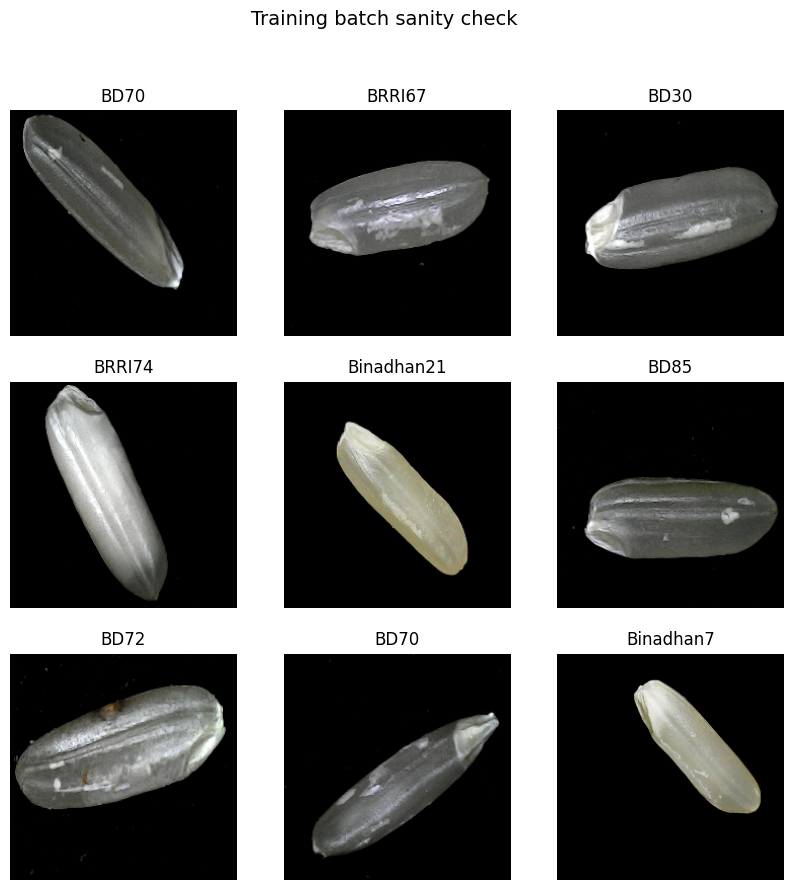

In [21]:
def unnormalize(img):
    # img is normalized tensor
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

# Take one batch
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = unnormalize(images[i]).numpy()
    plt.imshow(img)
    plt.title(id_to_label[int(labels[i])])
    plt.axis("off")

plt.suptitle("Training batch sanity check", fontsize=14)
plt.show()
